In [1]:
import numpy as np
from copulas.univariate import GaussianKDE 
from copulas.bivariate import Clayton
from scipy.stats import t
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
from collections import OrderedDict
import pandas as pd
import random
from scipy.stats import genpareto
from scipy.stats import expon,poisson,pareto
import pathlib



C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


# I. Joint Simulation Algorithm

In [2]:
def prodInd(j,deltaMatrix):
    vectDelta_j = list(deltaMatrix[:,j])
    vectDelta_j.remove(vectDelta_j[j])
    return np.prod(np.array(vectDelta_j)<0)
def ComputeWk(k,deltaMatrix):
    K = deltaMatrix.shape[0]
    Delta = list(deltaMatrix[k,:])
    Delta.remove(Delta[k])
    Ind = [prodInd(j,deltaMatrix)  for j in range(K) if j != k]
    WwoE = np.dot(np.array(Delta),np.array(Ind))
    return WwoE

def DeltaMatrix(i,DELTA,K):
    deltaMatrix_i = np.zeros((K,K))
    deltaMatrix_i[0,1:] = DELTA.iloc[i,:]
    deltaMatrix_i[:,0] = - deltaMatrix_i[0,:] 
    for k in range(1,K):
        for l in range(k,K):
            if k != l:
                deltaMatrix_i[k,l] = deltaMatrix_i[0,l] - deltaMatrix_i[0,k]
                deltaMatrix_i[l,k] = -deltaMatrix_i[k,l]

    return deltaMatrix_i

## The following function define our joint simulation algorithm 
def simulation(sample,M,replacing=False):
    N,K = sample.shape
    DELTA = pd.DataFrame(columns=np.arange(K-1),index=np.arange(N))
    newSample = pd.DataFrame(columns=np.arange(K),index=np.arange(M))
    for k in range(0,K-1):
        DELTA.iloc[:,k] = sample.iloc[:,0] - sample.iloc[:,k+1]
    if replacing :
        Msample = DELTA.iloc[np.random.choice(list(np.arange(N)),M),:]
    else :
        Msample = DELTA.iloc[random.sample(list(np.arange(N)),M),:]
    E = expon.rvs(size=M)

    for m in range(M):
        deltaMatrix_m = DeltaMatrix(m,Msample,K)
        for k in range(K):
            newSample.iloc[m,k] = E[m] +  ComputeWk(k,deltaMatrix_m)
    return newSample

# I. Simulation Illustration

In [3]:
sns.set_theme(style='white')
alphaVaR = 0.9975
alphaU = 0.85
plt.rcParams["figure.figsize"] = (10,5)


In [6]:
path = r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Data\DataK3ExtremalCoefficient\Gumbel70'
name =  'Gumbel70_2'#'Gumbel60_22'

    
filename = name
 # This data is generated using Gumbel copula of parameter theta = log(2)/log(2-0.7) and is in uniform scale 
Data = pd.read_excel(pathlib.PurePath(path, filename + '.xlsx'))
nu1,nu2,nu3= 2,3,2.5
#chiCopula = 0.7

# Original scale data

X = (t.ppf(Data.values[:,0],df=nu1)).reshape(-1,1)
Y = (t.ppf(Data.values[:,1],df=nu2)).reshape(-1,1)
Z = ((t.ppf(Data.values[:,2],df=nu3))).reshape(-1,1)
df = pd.DataFrame(np.concatenate([X,Y,Z],axis=1))
n,K = df.shape

VaRTheo = t.ppf(alphaVaR,df=nu1)
ESEmp = np.mean(X[X>VaRTheo]) 

# Transformation of data from the uniform scale to exponential scale

X0 = (-np.log(1-Data.iloc[:,0].values)).reshape(-1,1)
Y0 = (-np.log(1-Data.iloc[:,1].values)).reshape(-1,1)
Z0 = (-np.log(1-Data.iloc[:,2].values)).reshape(-1,1)
dfStand = pd.DataFrame(np.concatenate([X0,Y0,Z0],axis=1))

# Fixing thresholds 
uX0,uY0,uZ0 = np.quantile(X0,alphaU),np.quantile(Y0,alphaU),np.quantile(Z0,alphaU)

print(f'Gamma of X0 = %.2f'%(genpareto.fit(X0[X0>uX0]-uX0)[0]))
print(f'Gamma of Y0 = %.2f'%(genpareto.fit(Y0[Y0>uY0]-uY0)[0]))
print(f'Gamma of Z0 = %.2f'%(genpareto.fit(Z0[Z0>uZ0]-uZ0)[0]))


# Selecting observations exceeding their threshold 
TX0 = (np.arange(n)[dfStand.iloc[:,0]>uX0]).reshape(-1,)
TY0 = (np.arange(n)[dfStand.iloc[:,1]>uY0]).reshape(-1,)
TZ0 = (np.arange(n)[dfStand.iloc[:,2]>uZ0]).reshape(-1,)

T0 = np.concatenate([TX0,TY0,TZ0])

# Computation of Excesses as Z = X0 -uX0 on observations of random vector for which at least one component exceeds its VaR level
T0 = np.array(list(OrderedDict.fromkeys(list(T0))),dtype=int)
ExcessStand = dfStand.iloc[T0,:]
ExcessStand.iloc[:,0] = ExcessStand.iloc[:,0] - uX0
ExcessStand.iloc[:,1] = ExcessStand.iloc[:,1] - uY0
ExcessStand.iloc[:,2] = ExcessStand.iloc[:,2] - uZ0

ExcessStand = ExcessStand.values

Gamma of X0 = 0.08
Gamma of Y0 = 0.04
Gamma of Z0 = 0.05


C:\Users\nmadhar\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1951: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[selected_item_labels] = value


In [7]:
# Computing VaR in the original scale 
VaRX, VaRY,VaRZ = t.ppf(alphaVaR,df=nu1),t.ppf(alphaVaR,df=nu2),t.ppf(alphaVaR,df=nu3)

# Encoding observations exceeding the VaR level associate to the the variable in the original scale, 
# 1 if it excceeds the VaR and 0 otherwise 

stateX = (df.iloc[:,0]>VaRX).astype(int)
stateY = (df.iloc[:,1]>VaRY).astype(int)
stateZ = (df.iloc[:,2]>VaRZ).astype(int)

TX = (np.arange(n)[df.iloc[:,0]>VaRX]).reshape(-1,)
TY = (np.arange(n)[df.iloc[:,1]>VaRY]).reshape(-1,)
TZ = (np.arange(n)[df.iloc[:,2]>VaRZ]).reshape(-1,)

T = np.concatenate([TX,TY,TZ])

T = np.array(list(OrderedDict.fromkeys(list(T))),dtype=int)

# Selecting observations of the random vector for which at least one component exceeds its VaR level in the original scale, 


Excess = df.iloc[T,:]
Excess.iloc[:,0] = Excess.iloc[:,0] 
Excess.iloc[:,1] = Excess.iloc[:,1] 
Excess.iloc[:,2] = Excess.iloc[:,2] 

Excess = Excess.values

stateeOriginalX = (Excess[:,0]>VaRX).astype(int)
stateeOriginalY = (Excess[:,1]>VaRY).astype(int)
stateeOriginalZ = (Excess[:,2]>VaRZ).astype(int)


In [8]:
# Defining Color Encoding 
## 0 --> 0 component exceeds its VaR level , 1--> 1 component exceeds its VaR level, 
## 2 --> 2 components exceed their respective  VaR level, 3 --> 3 components exceed their respective  VaR level, 
colors = np.array(stateX.values+stateY.values+stateZ.values,dtype='str')
colors[colors=='0'] = sns.cubehelix_palette().as_hex()[0]
colors[colors=='1'] = sns.cubehelix_palette().as_hex()[2]
colors[colors=='2'] = sns.cubehelix_palette().as_hex()[3]
colors[colors=='3'] = sns.cubehelix_palette().as_hex()[4]
# Defining Marker Encoding 

mymark = {0:'o',1:'d',2:'X',3:'P'}
df.columns = ['X1','X2','X3']

# II. Representation of the pre-processing steps 
## 1. Original Scale

Representation of the observations in the original scale.

First component vs second in the original scale, the color of each observation indicates the value of the third component, while the marker encodes the number of component of the observation of the random exceeding their respective VaR.

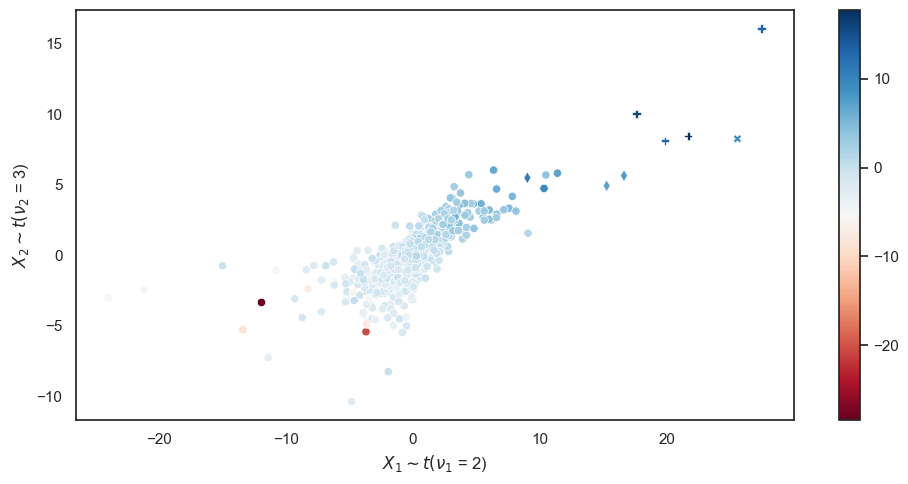

In [9]:
_,ax = plt.subplots(1, 1)


scatter1 = sns.scatterplot(x='X1',y='X2',hue='X3',data=df,style=stateX+stateY+stateZ,palette='RdBu',ax=ax, markers=mymark)
ax.set(xlabel=r'$X_1 \sim t(\nu_1$ =%2.f)'%nu1, ylabel=r'$X_2 \sim t(\nu_2$ =%2.f)'%nu2)
norm = plt.Normalize(df.iloc[:,2].min(), df.iloc[:,2].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

scatter1.get_legend().remove()
scatter1.figure.colorbar(sm,ax=ax)
plt.tight_layout()

#plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70.pdf')
plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70.png')


First component vs second in the original scale, the observation color indicates whether the value of the third component exceeds its VaR level (in red) or not (in grey), the vertical and horizontal line being the VaR level associated respectively with the first and second component.The four red points are observed in the upper right square represent the observations for which all components have exceeded their VaR level. 

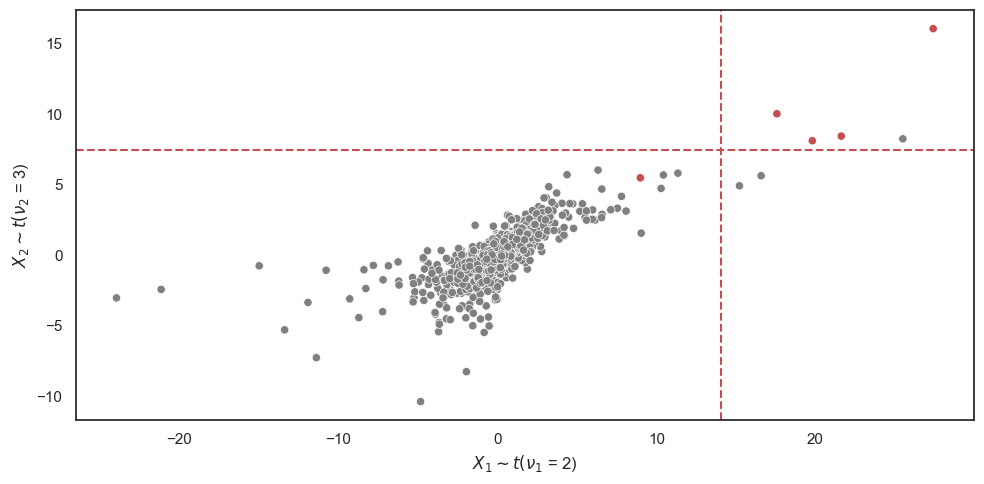

In [10]:
_,ax = plt.subplots(1, 1)

scatter2 = sns.scatterplot(x='X1',y='X2',data=df,hue=stateZ,ax=ax, palette=['grey','r'])
ax.set(xlabel=r'$X_1 \sim t(\nu_1$ =%2.f)'%nu1, ylabel=r'$X_2 \sim t(\nu_2$ =%2.f)'%nu2)
scatter2.get_legend().remove()


ax.axvline(VaRX,linestyle='--',color='r')
ax.axhline(VaRY,linestyle='--',color='r')
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70_12.png')


First component vs third in the original scale, the observation color indicates whether the value of the second component exceeds its VaR level (in red) or not (in grey), the vertical and horizontal line being the VaR level associated respectively with the first and third component

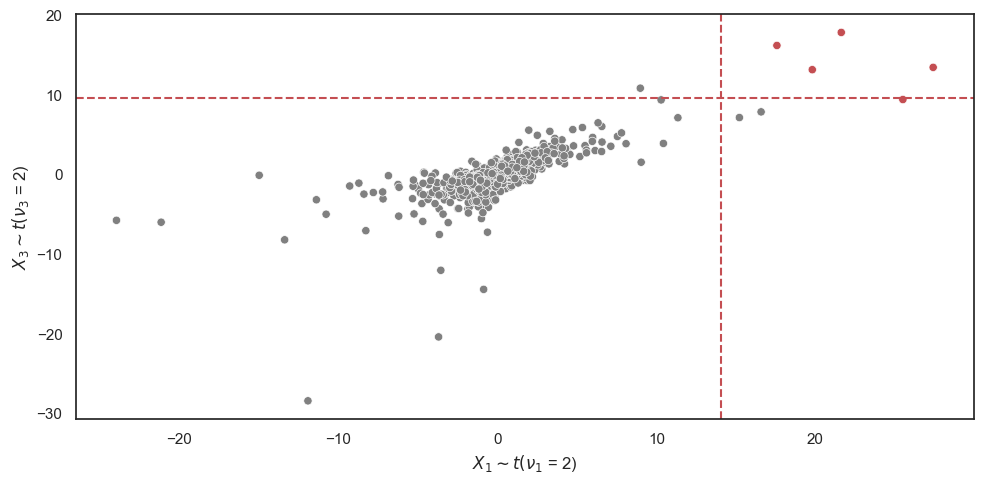

In [11]:
_,ax = plt.subplots(1, 1)

################## 1 vs 3

scatter2 = sns.scatterplot(x='X1',y='X3',data=df,hue=stateY,ax=ax, palette=['grey','r'])
ax.set(xlabel=r'$X_1 \sim t(\nu_1$ =%2.f)'%nu1, ylabel=r'$X_3 \sim t(\nu_3$ =%2.f)'%nu3)
scatter2.get_legend().remove()


ax.axvline(VaRX,linestyle='--',color='r')
ax.axhline(VaRZ,linestyle='--',color='r')
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70_13.png')



Second compoent vs third in the original scale, the observation color indicates whether the value of the first component exceeds its VaR level (in red) or not (in grey), the vertical and horizontal line being the VaR level associated respectively with the second and third component

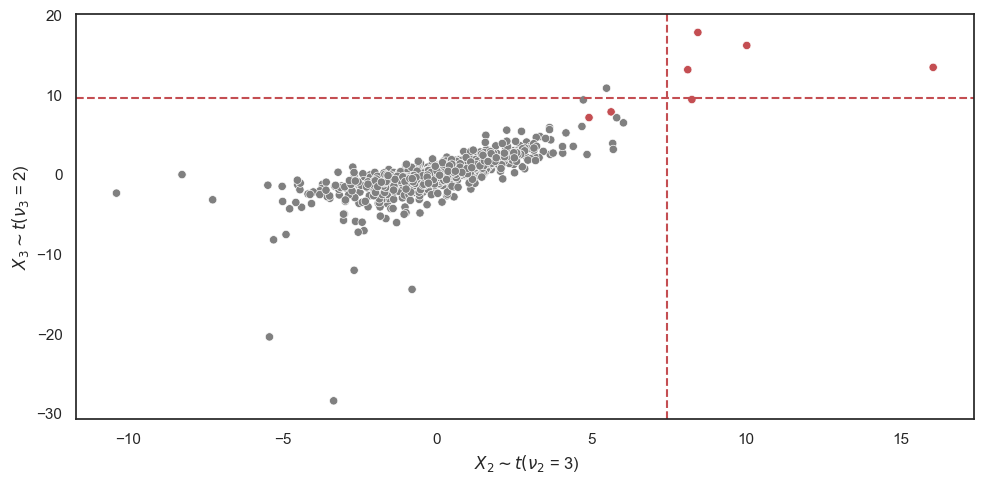

In [12]:
_,ax = plt.subplots(1, 1)

################## 2 vs 3

scatter2 = sns.scatterplot(x='X2',y='X3',data=df,hue=stateX,ax=ax, palette=['grey','r'])
ax.set(xlabel=r' $X_2 \sim t(\nu_2$ =%2.f)'%nu2, ylabel=r'$X_3 \sim t(\nu_3$ =%2.f)'%nu3)
scatter2.get_legend().remove()


ax.axvline(VaRY,linestyle='--',color='r')
ax.axhline(VaRZ,linestyle='--',color='r')
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70_23.png')


## 2.  Exponential Scale 

Representation of the observations in the exponential scale.

First vs second components in the exponential scale, the color of each observation indicates the value of the third component, while the marker encodes the number of component of the observation of the random exceeding their respective VaR.

In [13]:
## Transformation VaR level into the exponential scale 
VaRX0,VaRY0,VaRZ0 = expon.ppf(t.cdf(VaRX,df=nu1)),expon.ppf(t.cdf(VaRY,df=nu2)),expon.ppf(t.cdf(VaRZ,df=nu3))

# Encoding observations exceeding the VaR level associate to the the variable in the exponential scale, 
# 1 if it excceeds the VaR and 0 otherwise 

stateX0 = (dfStand.iloc[:,0]>VaRX0).astype(int)
stateY0 = (dfStand.iloc[:,1]>VaRY0).astype(int)
stateZ0 = (dfStand.iloc[:,2]>VaRZ0).astype(int)

dfStand.columns =['X1','X2','X3']

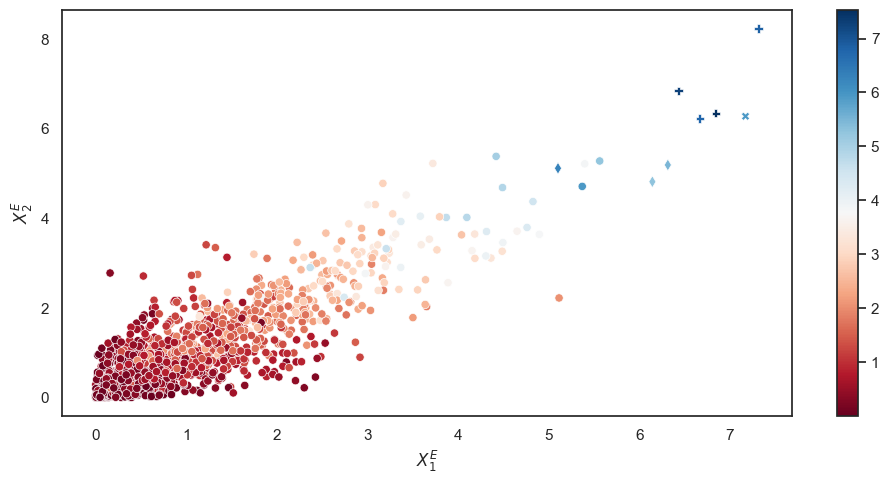

In [14]:
_,ax = plt.subplots(1, 1)

# 1 vs 2

scatter1 = sns.scatterplot(x='X1',y='X2',hue='X3',data=dfStand,style=stateX0+stateY0+stateZ0,palette='RdBu',ax=ax, markers=mymark)
ax.set(xlabel=r'$X_1^E$', ylabel=r'$X_2^E$')
norm = plt.Normalize(dfStand.iloc[:,2].min(), dfStand.iloc[:,2].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

scatter1.get_legend().remove()
scatter1.figure.colorbar(sm,ax=ax)
plt.tight_layout()

#plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70.pdf')
plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70Exp.png')


First component vs second in the exponential scale, the observation color indicates whether the value of the third component exceeds its VaR level (in red) or not (in grey), the vertical and horizontal line being the VaR level associated respectively with the first and second component.The four red points are observed in the upper right square represent the observations for which all components have exceeded their VaR level. 

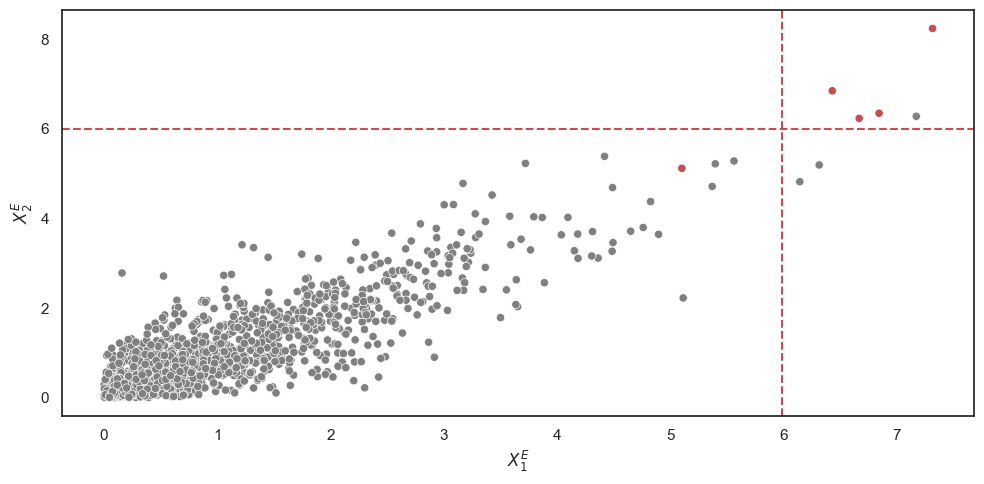

In [15]:
_,ax = plt.subplots(1, 1)

################## 1 vs 2

scatter2 = sns.scatterplot(x='X1',y='X2',data=dfStand,hue=stateZ0,ax=ax, palette=['grey','r'])
ax.set(xlabel=r'$X_1^E$', ylabel=r'$X_2^E$')
scatter2.get_legend().remove()


ax.axvline(VaRX0,linestyle='--',color='r')
ax.axhline(VaRY0,linestyle='--',color='r')
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70Exp_12.png')


First component vs third in the exponential scale, the observation color indicates whether the value of the second component exceeds its VaR level (in red) or not (in grey), the vertical and horizontal line being the VaR level associated respectively with the first and third component.

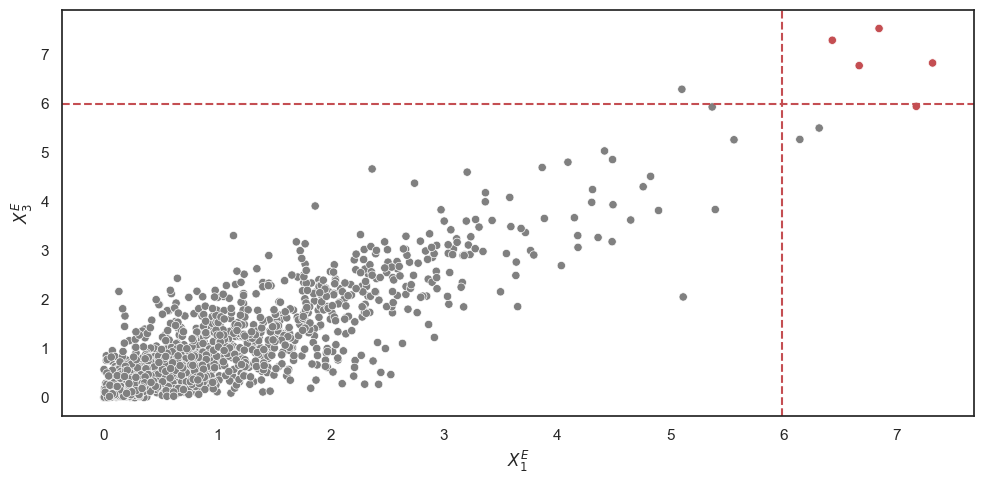

In [16]:
_,ax = plt.subplots(1, 1)

################## 1 vs 3

scatter2 = sns.scatterplot(x='X1',y='X3',data=dfStand,hue=stateY0,ax=ax, palette=['grey','r'])
ax.set(xlabel=r'$X_1^E$', ylabel=r'$X_3^E$')
scatter2.get_legend().remove()


ax.axvline(VaRX0,linestyle='--',color='r')
ax.axhline(VaRZ0,linestyle='--',color='r')
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70Exp_13.png')


Second component vs third in the exponential scale, the observation color indicates whether the value of the first component exceeds its VaR level (in red) or not (in grey), the vertical and horizontal line being the VaR level associated respectively with the first and third component.

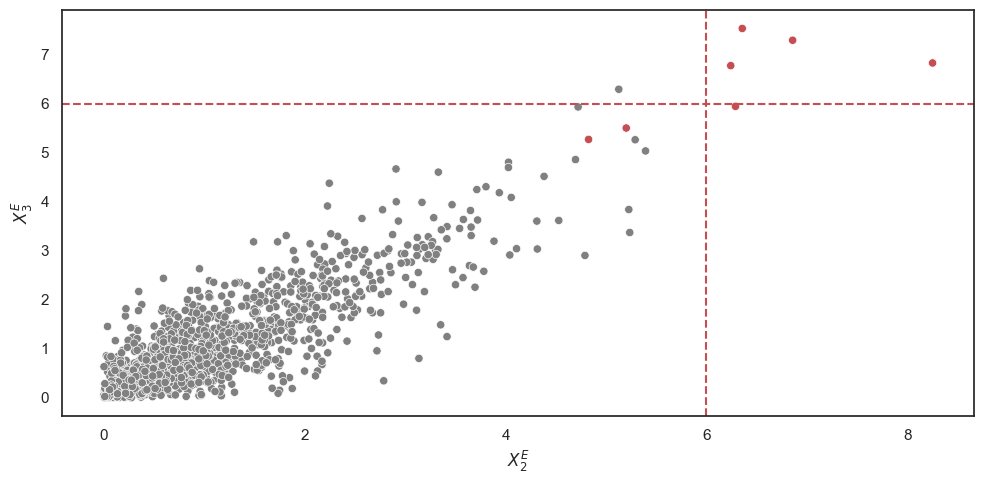

In [17]:
_,ax = plt.subplots(1, 1)

#2 vs 3

scatter2 = sns.scatterplot(x='X2',y='X3',data=dfStand,hue=stateX0,ax=ax, palette=['grey','r'])
ax.set(xlabel=r'$X_2^E$', ylabel=r'$X_3^E$')
scatter2.get_legend().remove()


ax.axvline(VaRY0,linestyle='--',color='r')
ax.axhline(VaRZ0,linestyle='--',color='r')
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70Exp_23.png')


## 3. Excess in the  Exponential Scale 

Representation of the excesses in the exponential scale.



In [18]:
VaRX0,VaRY0,VaRZ0 = expon.ppf(t.cdf(VaRX,df=nu1)),expon.ppf(t.cdf(VaRY,df=nu2)),expon.ppf(t.cdf(VaRZ,df=nu3))

stateX0E = (ExcessStand[:,0]>0).astype(int)
stateY0E = (ExcessStand[:,1]>0).astype(int)
stateZ0E = (ExcessStand[:,2]>0).astype(int)
ExcessStand = pd.DataFrame(ExcessStand)
ExcessStand.columns = ['X1','X2','X3']

Excesses on the first component vs excesses on the second component in the exponential scale, the color of each observation indicates the value of the third component, while the marker encodes the number of component of the observation of the random exceeding their respective threshold $u$.

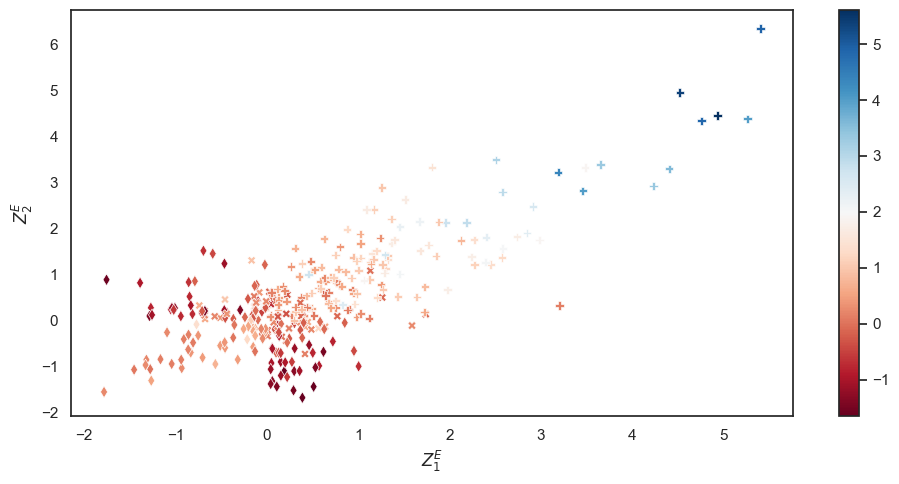

In [19]:
_,ax = plt.subplots(1, 1)

################## 1 vs 2

scatter1 = sns.scatterplot(x='X1',y='X2',data=ExcessStand,hue='X3',style=stateX0E+stateY0E+stateZ0E,palette='RdBu',ax=ax, markers=mymark)
ax.set(xlabel=r'$Z_1^E$ ', ylabel=r'$Z_2^E$')
norm = plt.Normalize(ExcessStand.iloc[:,2].min(), ExcessStand.iloc[:,2].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

scatter1.get_legend().remove()
scatter1.figure.colorbar(sm,ax=ax)
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70Exp_Excess.png')


Excesses on the first component vs excesses on the second component, the observation color indicates whether the value of the third component exceeds its threshold $u$ (in orange) or not (in grey), the red dotted vertical and horizontal line being the "VaR level -u"  associated respectively with the first and second component, while the black vertical and horizontal line represent the thresholds "$u-u=0$" associated respectively with the first and second component. 

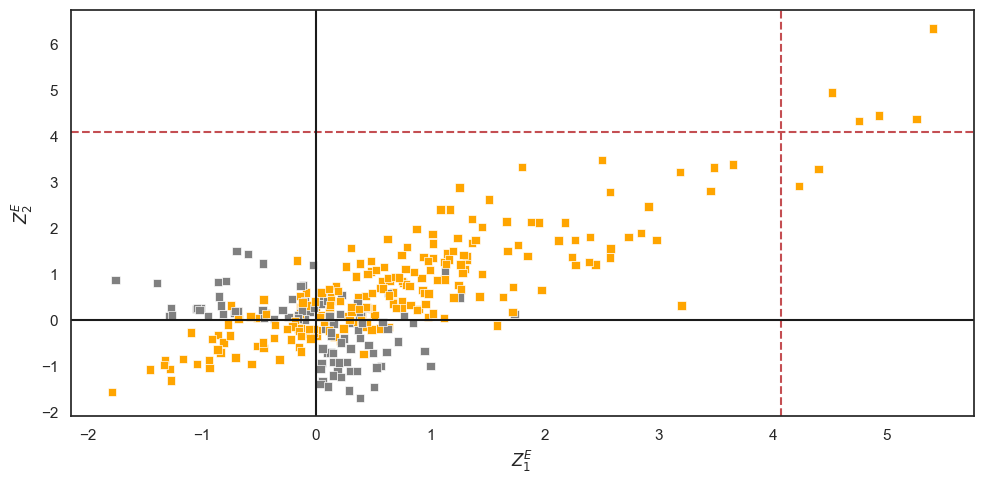

In [20]:
_,ax = plt.subplots(1, 1)

################## 1 vs 2

scatter2 = sns.scatterplot(x='X1',y='X2',data=ExcessStand,hue=stateZ0E,ax=ax, palette=['grey','orange'],marker='s')
ax.set(xlabel=r'$Z_1^E$', ylabel=r'$Z_2^E$')
scatter2.get_legend().remove()


ax.axvline(VaRX0-uX0,linestyle='--',color='r')
ax.axhline(VaRY0-uY0,linestyle='--',color='r')
ax.axvline(0,linestyle='-',color='k')
ax.axhline(0,linestyle='-',color='k')
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70Exp_Excess_12.png')


Excesses on the first component vs excesses on the third component, the observation color indicates whether the value of the second component exceeds its threshold $u$ (in orange) or not (in grey), the red dotted vertical and horizontal line being the "VaR level -u"  associated respectively with the first and third component, while the black vertical and horizontal line represent the thresholds "$u-u=0$" associated respectively with the first and third component. 

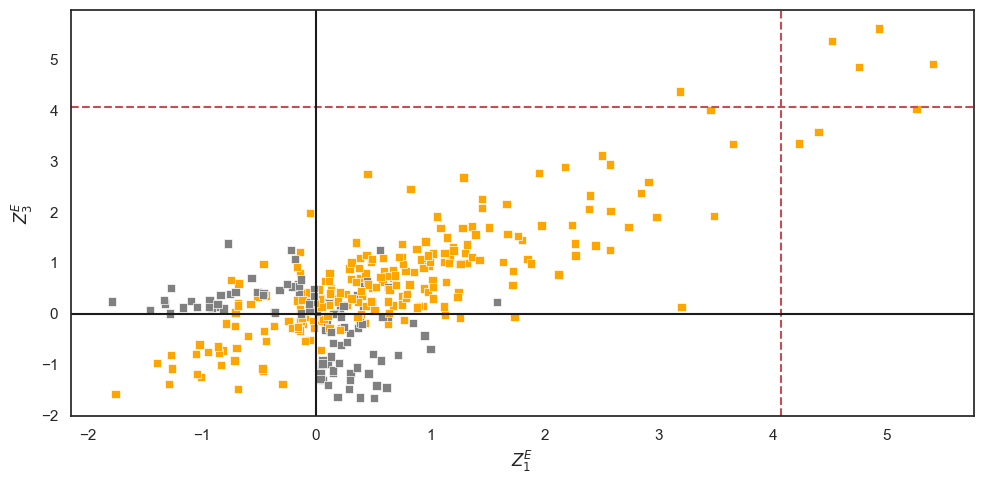

In [21]:
_,ax = plt.subplots(1, 1)

################## 1 vs 3

scatter2 = sns.scatterplot(x='X1',y='X3',data=ExcessStand,hue=stateY0E,ax=ax, palette=['grey','orange'],marker='s')
ax.set(xlabel=r'$Z_1^E$', ylabel=r'$Z_3^E$')
scatter2.get_legend().remove()


ax.axvline(VaRX0-uX0,linestyle='--',color='r')
ax.axhline(VaRZ0-uZ0,linestyle='--',color='r')
ax.axvline(0,linestyle='-',color='k')
ax.axhline(0,linestyle='-',color='k')
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70Exp_Excess_13.png')


Excesses on the second component vs excesses on the third component, the observation color indicates whether the value of the first component exceeds its threshold $u$ (in orange) or not (in grey), the red dotted vertical and horizontal line being the "VaR level -u"  associated respectively with the second and third component, while the black vertical and horizontal line represent the thresholds "$u-u=0$" associated respectively with the second and third component. 

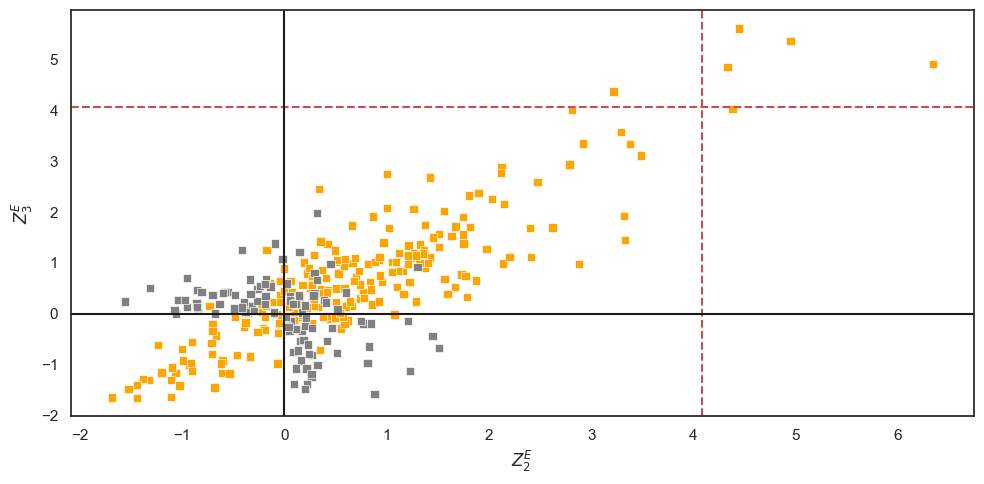

In [22]:
_,ax = plt.subplots(1, 1)

# 2 vs 3

scatter2 = sns.scatterplot(x='X2',y='X3',data=ExcessStand,hue=stateX0E,ax=ax, palette=['grey','orange'],marker='s')
ax.set(xlabel=r'$Z_2^E$', ylabel=r'$Z_3^E$')
scatter2.get_legend().remove()


ax.axvline(VaRY0-uY0,linestyle='--',color='r')
ax.axhline(VaRZ0-uZ0,linestyle='--',color='r')
ax.axvline(0,linestyle='-',color='k')
ax.axhline(0,linestyle='-',color='k')
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotGumbelwStudentMarginal_chi70Exp_Excess_13.png')


# III. Joint Simulation 

In [23]:
stateStandX = (dfStand.iloc[:,0]>uX0).astype(int)
stateStandY = (dfStand.iloc[:,1]>uY0).astype(int)
stateStandZ = (dfStand.iloc[:,2]>uZ0).astype(int)

stateeStandX = (ExcessStand.iloc[:,0]>0).astype(int)
stateeStandY = (ExcessStand.iloc[:,1]>0).astype(int)
stateeStandZ = (ExcessStand.iloc[:,2]>0).astype(int)


In [24]:
M =  1000

# Simulation of a sample of M=1000 new observations using the joint simulation algorithm in the exponential scale
NewExcessStandard = simulation(pd.DataFrame(ExcessStand),M,True)

# Transformation of new observations from the exponential scale to the original scale 
NewExcess = np.zeros(NewExcessStandard.shape)
NewExcess[:,0] = t.ppf((1-np.exp(-np.array(NewExcessStandard.iloc[:,0].values+uX0,dtype=float))),df=nu1)
NewExcess[:,1] = t.ppf((1-np.exp(-np.array(NewExcessStandard.iloc[:,1].values+uY0,dtype=float))),df=nu2)
NewExcess[:,2] = t.ppf((1-np.exp(-np.array(NewExcessStandard.iloc[:,2].values+uZ0,dtype=float))),df=nu3)


nan_rows = np.any(np.isnan(NewExcess),axis=1)
NewExcess = NewExcess[~nan_rows]
NewExcessStandard = NewExcessStandard[~nan_rows]
NewExcessStandard.columns = ['X1','X2','X3']

In [25]:
NewExcessStandardArray = NewExcessStandard.values
stateSimuX = (NewExcessStandardArray[:,0]>0).astype(int)
stateSimuY = (NewExcessStandardArray[:,1]>0).astype(int)
stateSimuZ = (NewExcessStandardArray[:,2]>0).astype(int)

Excesses on the first component vs excesses on the second component in the exponential scale generated using our joint simulation algorithm, the color of each observation indicates the value of the third component, while the marker encodes the number of component of the observation of the random exceeding their respective threshold $u$.

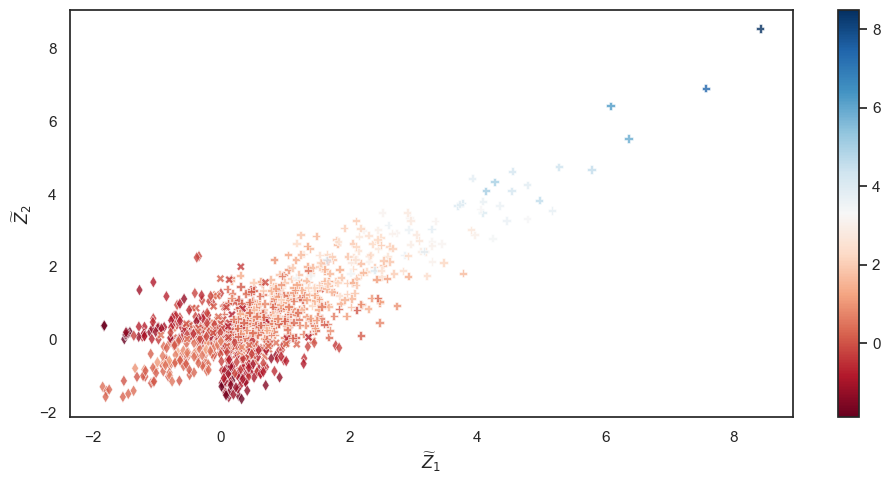

In [26]:
fig,ax = plt.subplots(1, 1,sharey=True)

scatter6 = sns.scatterplot(x='X1',y='X2',data=NewExcessStandard,alpha=0.8,label='Original',hue='X3',ax=ax,palette='RdBu',style=stateSimuX+stateSimuY+stateSimuZ,markers=mymark)
ax.set(xlabel=r'$\widetilde{Z}_1$', ylabel=r'$\widetilde{Z}_2$')
norm = plt.Normalize(NewExcessStandard.iloc[:,2].min(), NewExcessStandard.iloc[:,2].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

scatter6.get_legend().remove()
scatter6.figure.colorbar(sm)
plt.tight_layout()

plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotNewSimuGumbelwStudentMarginal_Stand_chi70_NewExcessExp.png')


In [27]:
stateSimuX = (NewExcess[:,0]>VaRX).astype(int)
stateSimuY = (NewExcess[:,1]>VaRY).astype(int)
stateSimuZ = (NewExcess[:,2]>VaRZ).astype(int)
NewExcess = pd.DataFrame(NewExcess)
NewExcess.columns =['X1','X2','X3']

First component vs second in the original scale generated with our joint simulation algorithm, the color of each observation indicates the value of the third component, while the marker encodes the number of component of the observation of the random exceeding their respective VaR.

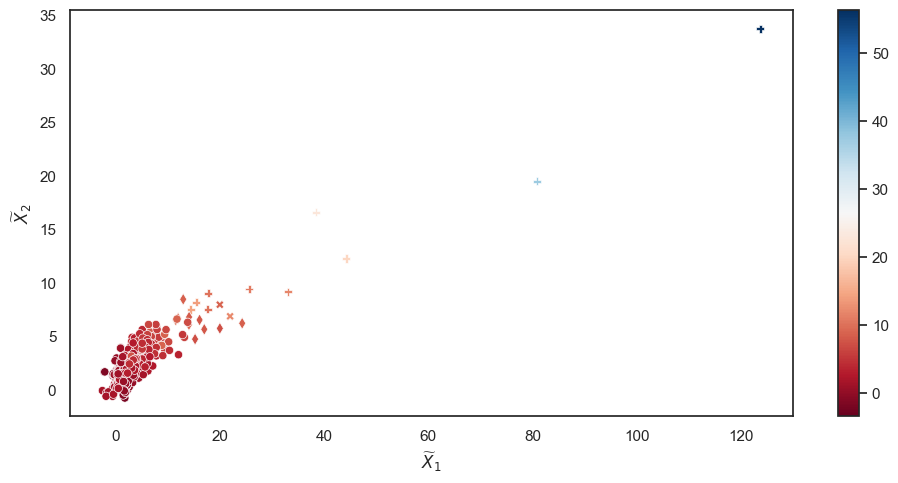

In [28]:
fig,ax = plt.subplots(1, 1,sharey=True)

scatter8 = sns.scatterplot(x='X1',y='X2',label='Original',hue='X3',data=NewExcess,ax=ax,palette='RdBu',style=stateSimuX+stateSimuY+stateSimuZ,markers=mymark)
ax.set(xlabel=r'$\widetilde{X}_1$', ylabel=r'$\widetilde{X}_2$')

norm = plt.Normalize(NewExcess.iloc[:,2].min(), NewExcess.iloc[:,2].max())
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=norm)
sm.set_array([])

scatter8.get_legend().remove()
scatter8.figure.colorbar(sm)
plt.tight_layout()


plt.savefig(r'C:\Users\nmadhar\Desktop\GANEV\SimulationOfExtremeScenarios\Results\FigureSimuSteps\K3\PlotNewSimuGumbelwStudentMarginal_Original_chi70__NewExcess.png')
